## Chapter 13: Multi-layer Perceptrons 

# 13.2 Architecture normalization

As we have seen, whenever we want to perform some sort of nonlinear regression or classification, we transform the input of a dataset using a linear combination of $B$ *nonlinear* feature transformations $f_1\,,f_2\,..,f_B$, having a model function that (for single dimensional input) looks like 

\begin{equation}
\text{model}\left({x},\mathbf{w}\right) = w_0 + f_1\left({x}\right) w_1 + \cdots + f_B\left({x}\right)w_B
\end{equation}

*In theory* the more feature transformations we use, or the more flexible each one is, the more nonlinear our prediction can be.  Indeed if we use too many we risk overfitting any dataset.  However *in practice* when optimizing (whether with nonlinear regression or classification) via *gradient descent* with a fixed number of maximum iterations we can often find that it gets harder to fit more nonlinear models to data.  In fact in some instances we can find that as we add nonlinear features our final fit becomes *less* nonlinear because our cost function has become harder for gradient descent to minimize properly. 

This confusing empirical fact is due to the fact that nonlinear feature transformations tend to *create* highly imbalanced input distributions, which in turn create the sort of long narrow valleys we try to avoid when using gradient descent as an optimizer (as detailed in Sections 8.4, 9.4, and 10.3).  To combat this problem we can would naturally *normalize the distribution of each and every feature transformation*, or in other words normalize every distribution that touches a parameter of the model.  Moreover if we wish to apply the same sort of logic to a (multilayer) perceptron - which has internal parameters at each layer touch the output activation distributions from prior layers, and which naturally change whenever e.g., a gradient descent step is made - we must normalize its internal parameters every time we make a parameter update.  This leads to the incorporation of a normalization step directly into the architecture itself - which is called every time weights are changed.  We refer to this as *architecture normalization* - but it often goes by the name of *batch normalization*. 

In [2]:
#  This code cell will not be shown in the HTML version of this notebook
# import autograd functionality
import autograd.numpy as np
from autograd.util import flatten_func
from autograd import grad as compute_grad   

# import various other libraries
import copy
import matplotlib.pyplot as plt

# this is needed to compensate for %matplotl+ib notebook's tendancy to blow up images when plotted inline
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

#  This code cell will not be shown in the HTML version of this notebook
# imports from custom library
import sys
sys.path.append('../../')
import autograd.numpy as np
from mlrefined_libraries import nonlinear_superlearn_library as nonlib
datapath = '../../mlrefined_datasets/nonlinear_superlearn_datasets/'
%matplotlib notebook
%load_ext autoreload
%autoreload 2

## 13.3.1  Fixed kernel feature transformations

To apply fixed features we take a set of *ordered basis functions* s $f_1,f_2,...,f_B$ (with no internal parameters) and transform the input.  In the next ``Python`` cell we give a compact feature transformation function called ``compute_features`` that does just this for *polynomial features*: we plug in our entire set of input and the first $U$ monomial features of it are returned.  In other words this returns a sequence of $P\times 1$ *transformed* inputs $\mathbf{f}_u$

\begin{equation}
\mathbf{f}_u = \begin{bmatrix}
f_u\left(x_1\right) \\
f_u\left(x_2\right) \\
\vdots \\
f_u\left(x_P\right) \\
\end{bmatrix}
\end{equation}

which contains each of our input points raised to the $u^{th}$ power.

In [2]:
# compact functionality for creating polynomial feature transformations - degree polynomials between 1 and U
def compute_features(x,U):
    return np.asarray([x**deg for deg in range(1,U+1)])[:,:,0].T

Remember: when employing such a fixed feature transformation $\mathbf{f}_u$ becomes our $u^{th}$ input dimension, and its distribution touches the weight $w_u$ (you can see this by examining the form of our ``predict`` function in equation (1)).  Thus having previously seen the effect of unnormalized versus normalized input feature distributions first hand in the case of *linear* regression / classification, we can expect something quite similar to arise in the nonlinear case based on the distribution of our features $\mathbf{f}_u$ (notice we never apply any 'normalization' to the bias since only one value touches it - the number $1$).  In other words, if the distributions of our transformed input dimensions are not by design similar, we can expect that normalizing them will substantially improve the performance of gradient descent since this will ameliorate (at least to some extent) the problem of long narrow valleys.

> If the distributions of our transformed input dimensions are not by design similar, we can expect that normalizing them will substantially improve the performance of gradient descent since this will ameliorate (at least to some extent) the problem of long narrow valleys.

#### <span style="color:#a50e3e;">Example 1. </span>  The distribution of polynomial features for a toy dataset

Lets begin by examining a the distribution of polynomial features for the toy sinusoidal dataset loaded in and shown below.

<IPython.core.display.Javascript object>


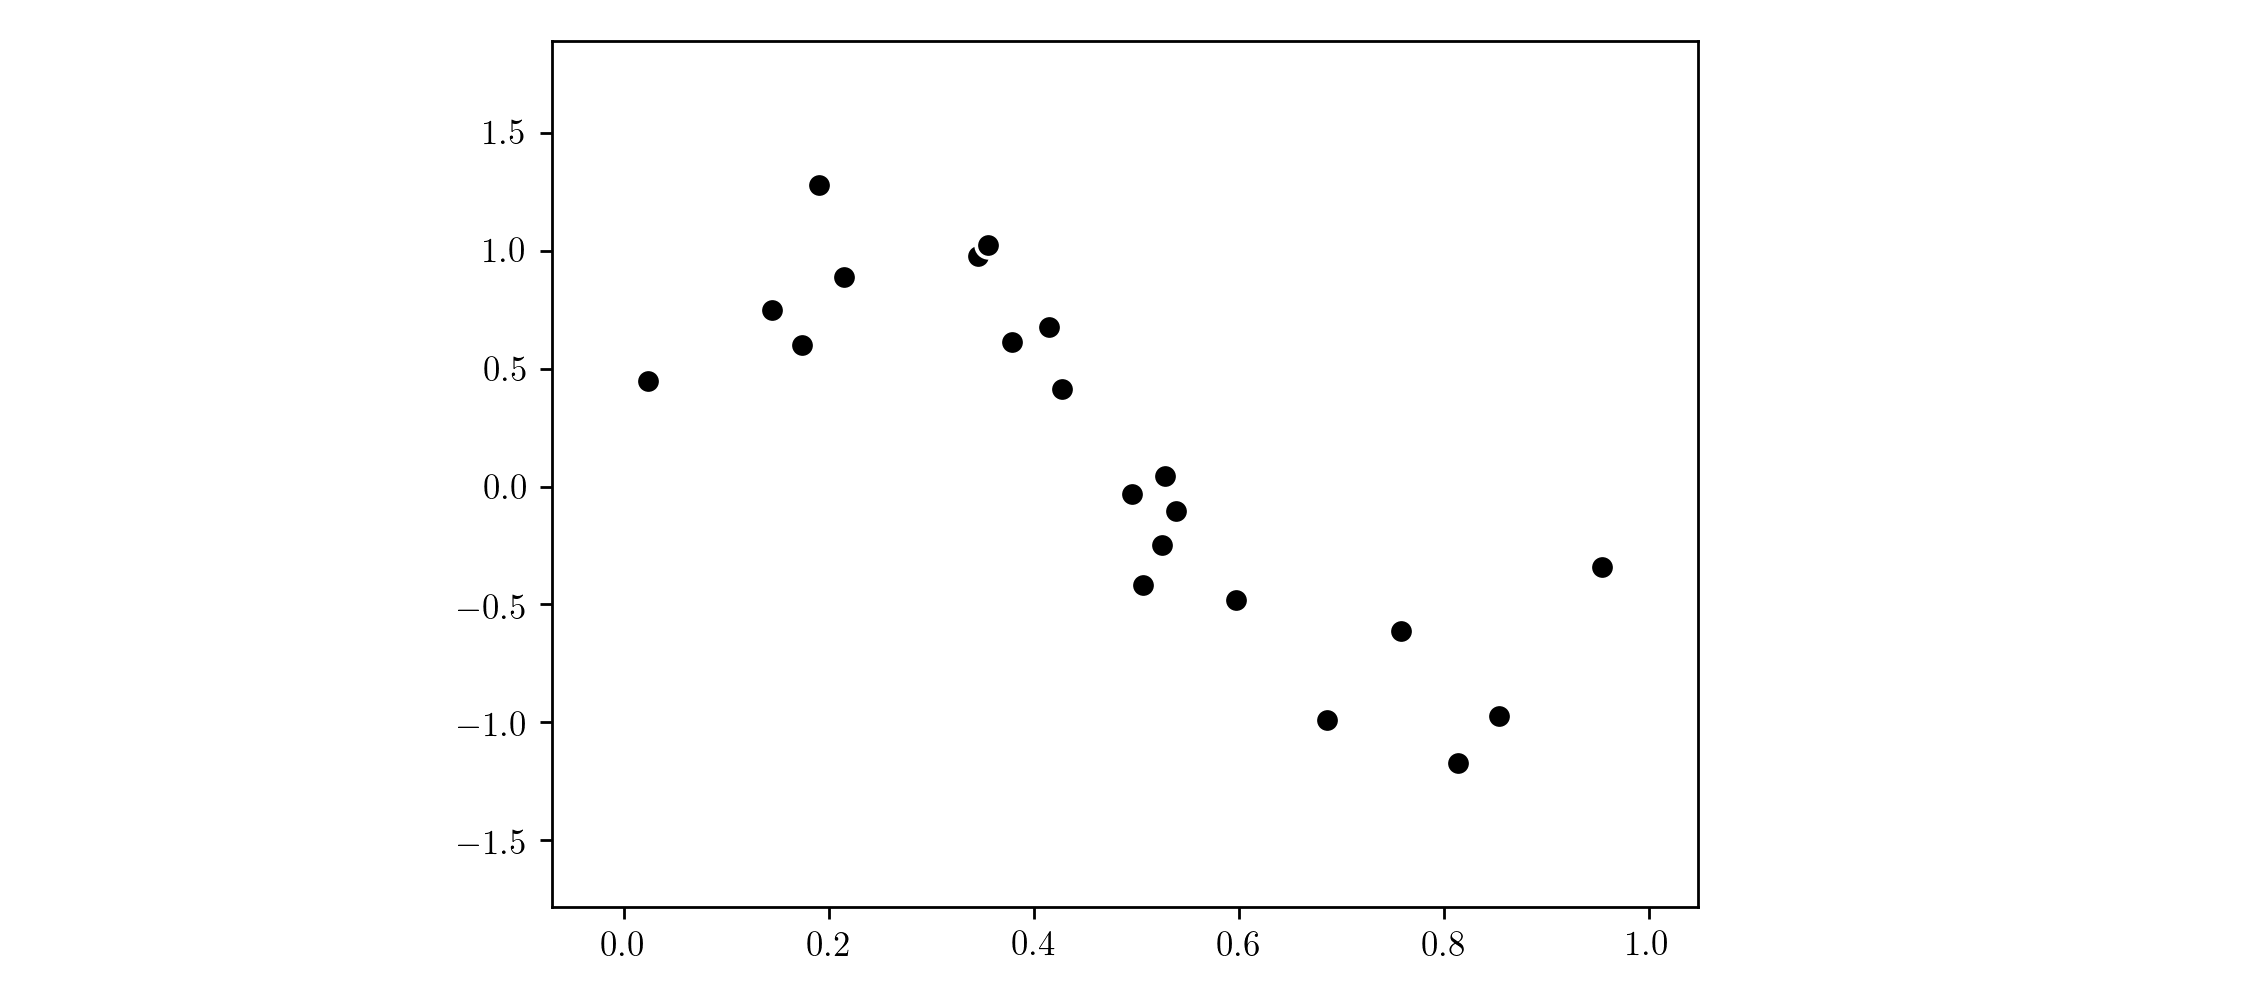

In [3]:
# load data
csvname = datapath + 'noisy_sin_sample.csv'
data = np.loadtxt(csvname,delimiter = ',')
x = data[:,:-1]
y = data[:,-1:]

# plot everything
plotter_demo = nonlib.custon_plotter.Visualizer()
plotter_demo.plot_regression_data(x,y)

To get a sense of the distribution of transformed features in our present case we can compute and plot each of the first $U = 20$ of them for our toy dataset.  We can examine then the distribution of each monomial feature using the ``feature_distributions`` plotting function introduced in the previous exercise.  A copy of this has been also in our ``custom_utilities`` backend file, and we can call it as shown below (no need to repeat the code block defining this function).

In [4]:
# make degree 20 polynomial features
U = 20
f = compute_features(x,U)

<IPython.core.display.Javascript object>


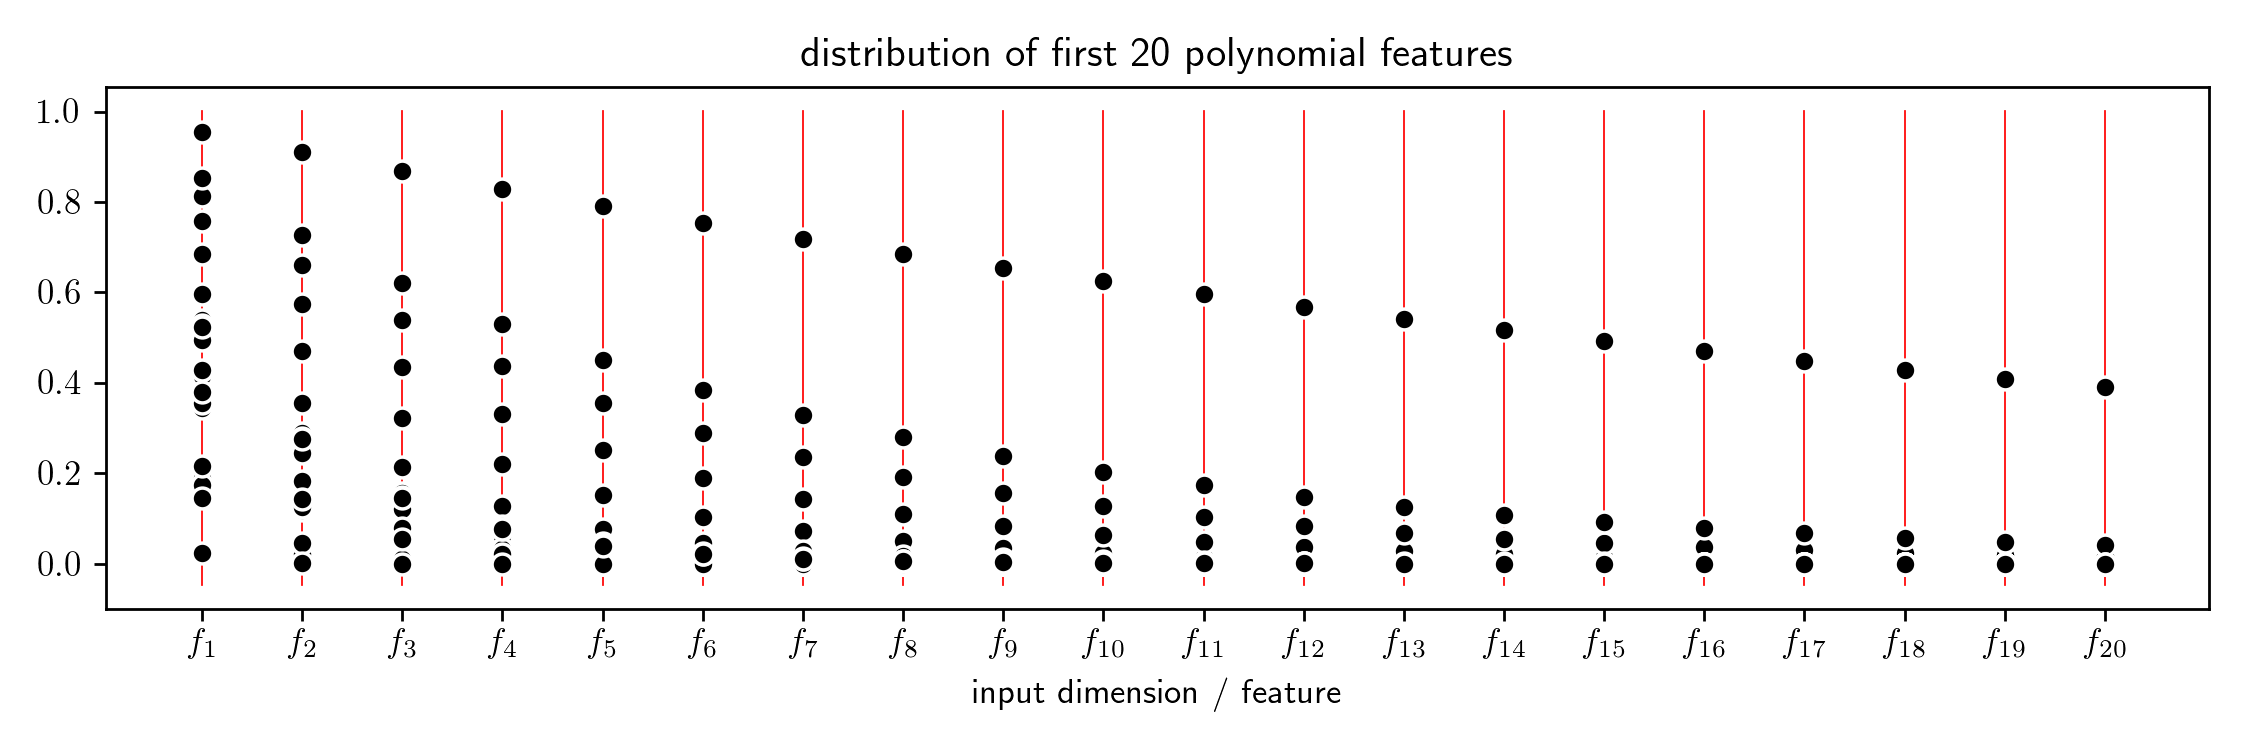

In [5]:
# show a plot of the distribution of each feature
title = 'distribution of first 20 polynomial features'
labels = [r'$f_{' + str(n+1) + '}$' for n in range(U)]
plotter_demo.feature_distributions(f,title,labels=labels)

These feature distributions are really collapsing rapidly and are - all together - not very similar across the feature space.  Why is this happening?  Because the input points in $\mathbf{x}$ here all lie in the range $[0,1]$, and raising any value in that range to a power makes it exponentially *smaller*.

Therefore we can expect gradient descent to be slow to converge if these unnormalized input features are used (an example below using our toy dataset will confirm this suspicion).  Indeed if left unnormalized this sort of feature distribution imbalance can lead to substantially increased difficulty in properly tuning nonlinear models (using gradient descent) as we increase the number of feature transformations $U$.  And we have done it to ourselves - in applying nonlinear feature transformations (here polynomials, but this is more commonly true as well) we *create* this problem.

> If left unnormalized fixed feature distribution imbalance can lead to substantially increased difficulty in properly tuning nonlinear models (using gradient descent) as we increase the number of fixed feature transformations $U$. 

At the extremes this can even lead to confusing scenarios where adding more nonlinear features does not improve the nonlinearity of a tuned model as one expects, because fine tuning via gradient descent has been made increasingly difficult with each added nonlinear feature dimension.  For example with polynomials - as indicated in our example here - the problem typically gets *worse* as we add more monomial terms since monomials exponentially *shrink* values in the interval $(-1,1)$ and exponentially *grow* essentially all other values (i.e., those with absolute value greater than 1).

---

Now when we take polynomial features we have some values that will grow exponentially *larger*.  So not even our standard normalization of the input can save us from ourselves in this case.  We need to normalize the nonlinear features themselves.  We normalize each by subtracting off their mean and dividing by their standard deviation

\begin{equation}
f_u \left(x_p \right) \longleftarrow \frac{f_u \left(x_p \right) - \mu_{f_u}}{\sigma_{f_u}}
\end{equation}

where

\begin{array}
\
\mu_{f_u} = \frac{1}{P}\sum_{p=1}^{P}f_u\left(x_p \right) \\
\sigma_{f_u} = \sqrt{\frac{1}{P}\sum_{p=1}^{P}\left(f_u\left(x_p \right) - \mu_{f_u} \right)^2}.
\end{array}

Normalizing both the original input and the nonlinear features we would likewise replace each feature with

\begin{equation}
f_u \left(x_p \right) \longleftarrow \frac{f_u \left(\frac{x_p - \mu_{x}}{\sigma_{x}} \right) - \mu_{f_u}}{\sigma_{f_u}}.
\end{equation}

With this input/feature normalization we can write our normalized ``predict_normalized`` function using this notation as

\begin{equation}
\text{predict_normalized}\left(x,\omega\right) = w_0 + w_1\left(\frac{f_1\left(\frac{x - \mu_x}{\sigma_x} \right) - \mu_{f_1}}{\sigma_{f_1}}\right) + w_2\left(\frac{f_2\left(\frac{x - \mu_x}{\sigma_x} \right) - \mu_{f_2}}{\sigma_{f_2}}\right) + \cdots + w_U\left(\frac{f_U\left(\frac{x - \mu_x}{\sigma_x} \right) - \mu_{f_U}}{\sigma_{f_U}}\right).
\end{equation} 

Now every weight in our model (with the exception of the bias of course) is attached to a normalized distribution of data.  Note in the instance our input $\mathbf{x}$ is in general $N$ dimensional we normalize along each coordinate, giving the general normalized update

\begin{equation}
\text{predict_normalized}\left(\mathbf{x},\omega\right) = w_0 + w_1\left(\frac{f_1\left(\frac{x_1 - \mu_{x_1}}{\sigma_{x_1}},\frac{x_2 - \mu_{x_2}}{\sigma_{x_2}},...,\frac{x_N - \mu_{x_N}}{\sigma_{x_N}} \right) - \mu_{f_1}}{\sigma_{f_1}}\right) + \cdots + w_U\left(\frac{f_U\left(\frac{x_1 - \mu_{x_1}}{\sigma_{x_1}},\frac{x_2 - \mu_{x_2}}{\sigma_{x_2}},...,\frac{x_N - \mu_{x_N}}{\sigma_{x_N}}  \right) - \mu_{f_U}}{\sigma_{f_U}}\right).
\end{equation} 

where $\mu_{x_n}$ and $\sigma_{x_n}$ are the mean and standard deviation of the data along the $n^{th}$ dimension of the input.

#### <span style="color:#a50e3e;">Example 2. </span>  The distribution of normalized polynomial features for a toy dataset

Here we normalize the input data and then corresponding polynomial featurese for the noisy sinusoidal dataset in Example 1.  Following we visualize the distribution of the first $U = 20$ normalized polynoimal features, mirroring the plot shown in the previous example.

In [6]:
# our normalization function
def normalize(data,data_mean,data_std):
    normalized_data = (data - data_mean)/data_std
    return normalized_data

In [7]:
# compute the mean and standard deviation of our input
x_means = np.mean(x,axis = 0)
x_stds = np.std(x,axis = 0)

# normalize data using the function above
x_normed = normalize(x,x_means,x_stds)

In [8]:
# make degree 5 polynomial features
U = 20
f = compute_features(x_normed,U)

# normalize polynomial features
f_means = np.mean(f,axis = 0)
f_stds = np.std(f,axis = 0)

# normalize features using the function above
f_normed = normalize(f,f_means,f_stds)

<IPython.core.display.Javascript object>


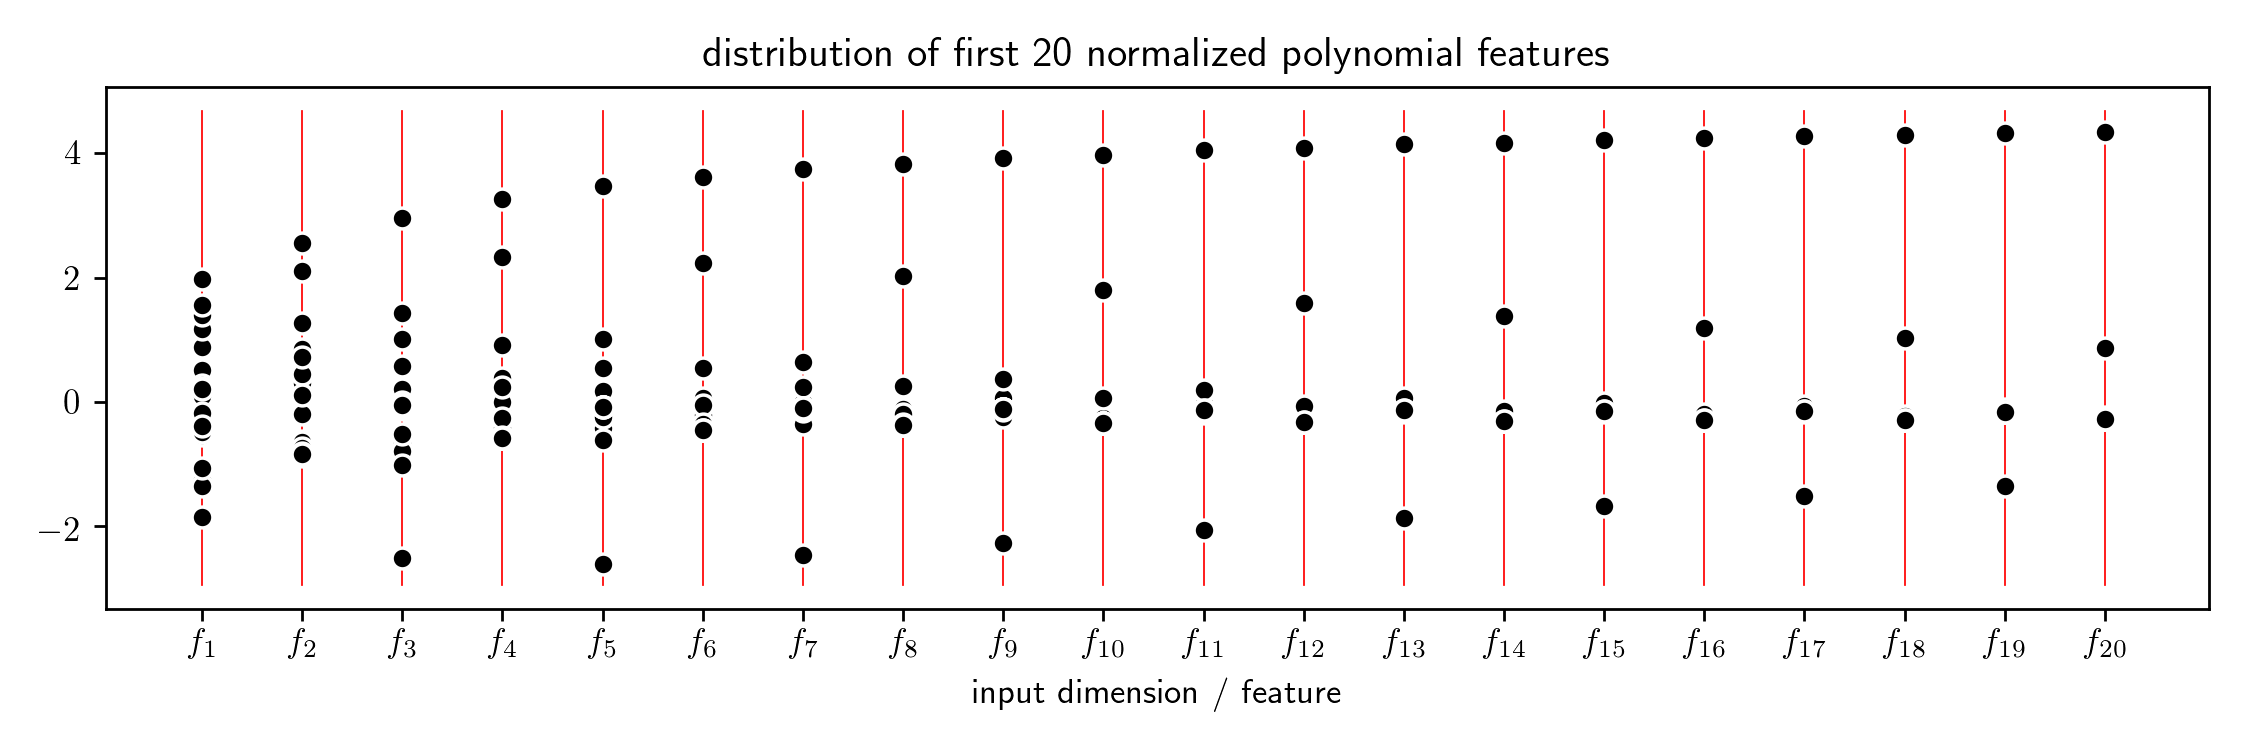

In [9]:
# show a plot of the distribution of each feature
title = 'distribution of first 20 normalized polynomial features'
labels = [r'$f_{' + str(n+1) + '}$' for n in range(U)]
plotter_demo.feature_distributions(f_normed,title,labels=labels)

Clearly normalizing does not completely fix the problem of uneven feature distributions here, as the *exponential* shrinking / enlarging property of polynomial terms is too powerful to be completely counteracted by mere normalization (this is indeed one of their major practical flaws).  However even so, normalization aids the convergence of gradient descent considerably - as we will see in the next example. 

#### <span style="color:#a50e3e;">Example 3. </span>  Unnormalized versus normalized polynomial features and gradient descent convergence

In this example we use a degree $U = 5$ polynomial model to fit our toy dataset and compare how rapidly the model can be properly tuned when we use the raw nonlinear features themselves versus when we normalize both the input data and features.  Starting with the unnormalized case, in the next cell we have our ``predict`` and ``least_squares`` implementations.  

In [10]:
# number of polynomial features to use
U = 5

# our predict function 
def predict(x,w):        
    # compute our current set of features
    f = compute_features(x,U)  

    # compute linear model
    vals = w[0] + np.dot(f,w[1:])
    return vals

# least squares
least_squares = lambda w: np.sum((predict(x,w) - y)**2)

Note how our implementation is a direct translation of the ``predict`` formula in equation (1), which we have done for ease of exposition.  However the way this is implemented polynomial features will be computed for the input of our toy dataset every time ``predict`` is called (i.e., at every step of gradient descent).  Since the polynomials have no internal weights that need updating from one descent step to another this is computationally wasteful, but on such a small dataset like the one we deal with here the overhead is not significant.

In the next cell we run gradient descent to fit our polynomial model using unnormalized gradient descent with a steplength parameter $\alpha$ of the form $10^{-\gamma}$ where $\gamma$ is the smallest positive integer that produces convergence with an initial point $\mathbf{w}^0 = \begin{bmatrix} 0 \\ \vdots \\ 0 \end{bmatrix}$ at the origin (all zeros).

In [11]:
# parameters of gradient descent
alpha = 10**(-2); max_its = 1000; beta = 0; w_init = np.zeros((U+1,1));
w_init = 0.1*np.random.randn(U+1,1)

# run desired algo with initial point, max number of iterations, etc.,
opt = nonlib.optimimzers.MyOptimizers()
weight_history_1 = opt.gradient_descent(g = least_squares,w = w_init,max_its = max_its,alpha = alpha,version = 'unnormalized',output = 'history')
cost_history_1 = [least_squares(v) for v in weight_history_1]

To evaluate new testing input using our trained model we simply plug them into our ``predict`` function (we will do this after running the normalized version of this experiment). 

Now we repeat the same experiment only we normalize both our input and polynomial features.  Here will see that far fewer gradient descent steps are needed to produce an even better fit.  In what follows we will implement the input and feature normalized prediction function precisely as stated in equation (5) above.  First, however, we need to compute the input and feature statistics (their mean and standard deviations). 

In [12]:
# compute the mean and standard deviation of the input
x_means = np.mean(x,axis = 0)
x_stds = np.std(x,axis = 0)

# normalize input using the statistics above
x_normed = normalize(x,x_means,x_stds)

# compute features of our normalized input
f = compute_features(x_normed,U)  

# compute the mean and standard deviation of our features
f_means = np.mean(f,axis = 0)
f_stds = np.std(f,axis = 0)

With these statistics in hand, we can then implement our input/feature normalized ``predict`` function.  Again this implementation - while a direct translation of the ``predict_normalized`` formula in equation (5) - is inefficient: since polynomials have no internal parameters we can pre-compute the normalized features on the training input beforehand (instead of re-computing these whenever ``predict_normalized`` is called), but for our small toy dataset this overhead will not be prohibitive.

In [13]:
# our predict function 
def predict_normalized(x,w):   
    # normalize input
    x_normed = normalize(x,x_means,x_stds)
    
    # compute features of normalized input
    f = compute_features(x_normed,U)  

    # normalize the training data features 
    f_normed = normalize(f,f_means,f_stds)

    # compute linear model
    vals = w[0] + np.dot(f_normed,w[1:])
    return vals

# least squares
least_squares = lambda w: np.sum((predict_normalized(x,w) - y)**2)

Now we run gradient descent using the same parameters as previously, though note a smaller steplength parameter $\alpha$ (of our generic form $10^{-\gamma}$ had to be used.

In [14]:
# parameters of gradient descent
alpha = 10**(-3); max_its = 1000; beta = 0; w_init = w_init;

# run gradient descent, create cost history (for cost function plot comparison) associated with output weight history
# run desired algo with initial point, max number of iterations, etc.,
opt = nonlib.optimimzers.MyOptimizers()
weight_history_2 = opt.gradient_descent(g = least_squares,w = w_init,max_its = max_its,alpha = alpha,version = 'unnormalized',output = 'history')
cost_history_2 = [least_squares(v) for v in weight_history_2]

With both experiments now complete we can compare the cost function history of each gradient descent run.  We do this in the cell below.  In the normalized case we converge much more rapidly than the unnormalized case.

<IPython.core.display.Javascript object>


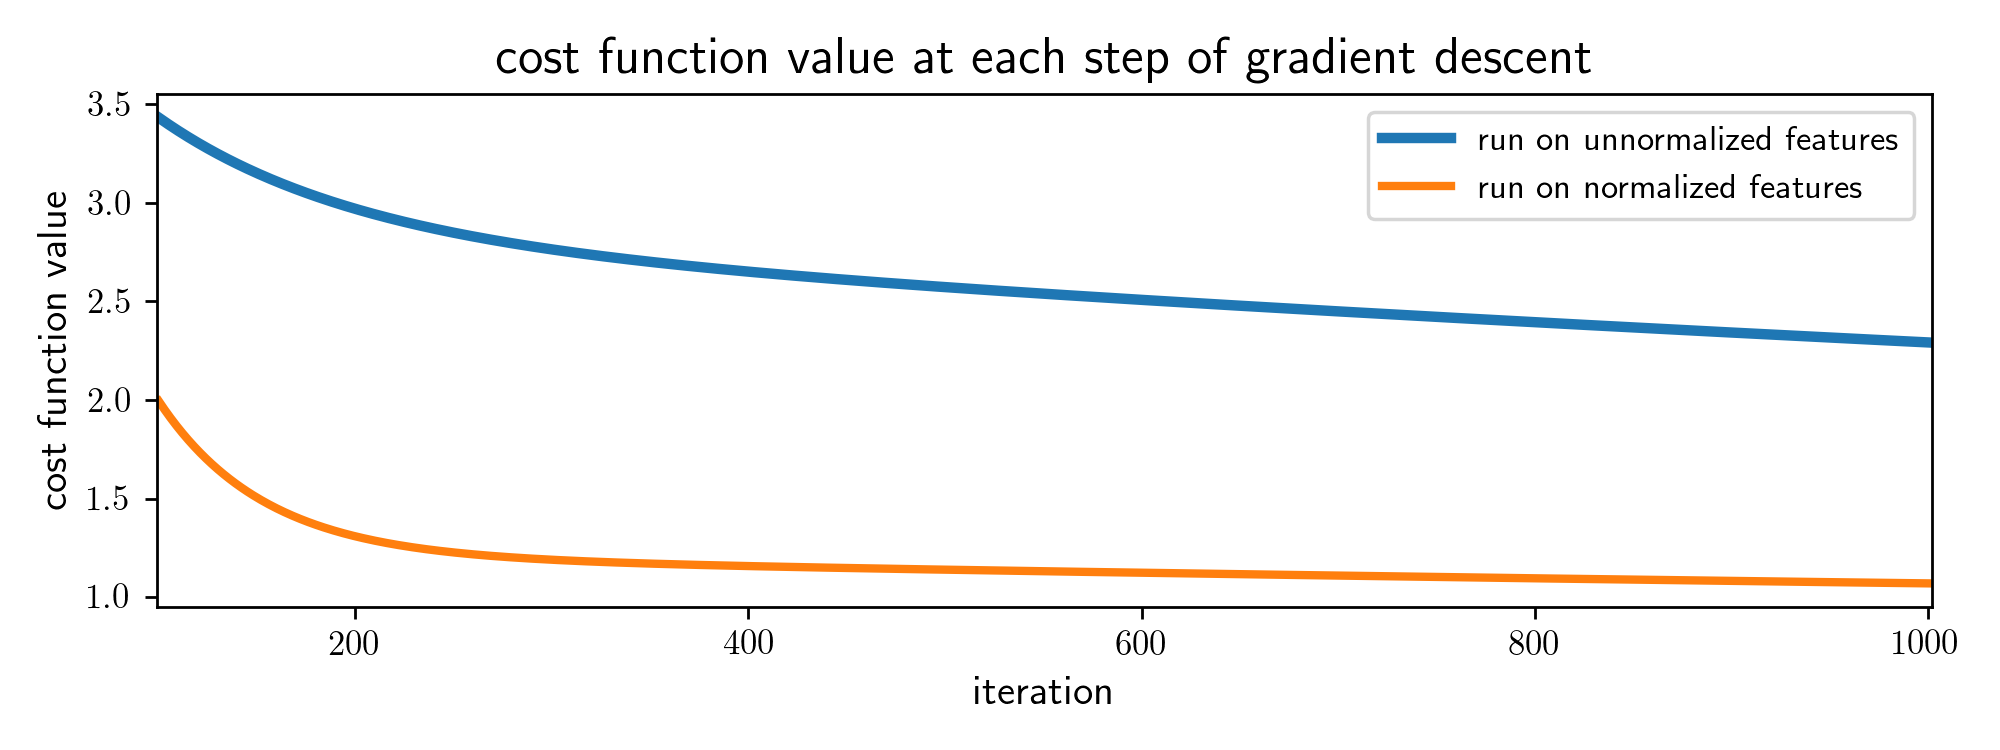

In [15]:
# plot the cost function history for our current run of gradient descent
histories = [cost_history_1, cost_history_2]
labels = ['run on unnormalized features','run on normalized features']
plotter_demo.compare_regression_histories(histories,start=100,labels=labels)

Now we can evaluate either version of the degree 5 model with new testing data.  Doing this for a fine sampling of input points along the interval where our toy data is defined we can visualize our nonlinear fit to the data.  Clearly (from the cost history plot above) the normalized version will produce the better fit - and indeed it does.

<IPython.core.display.Javascript object>


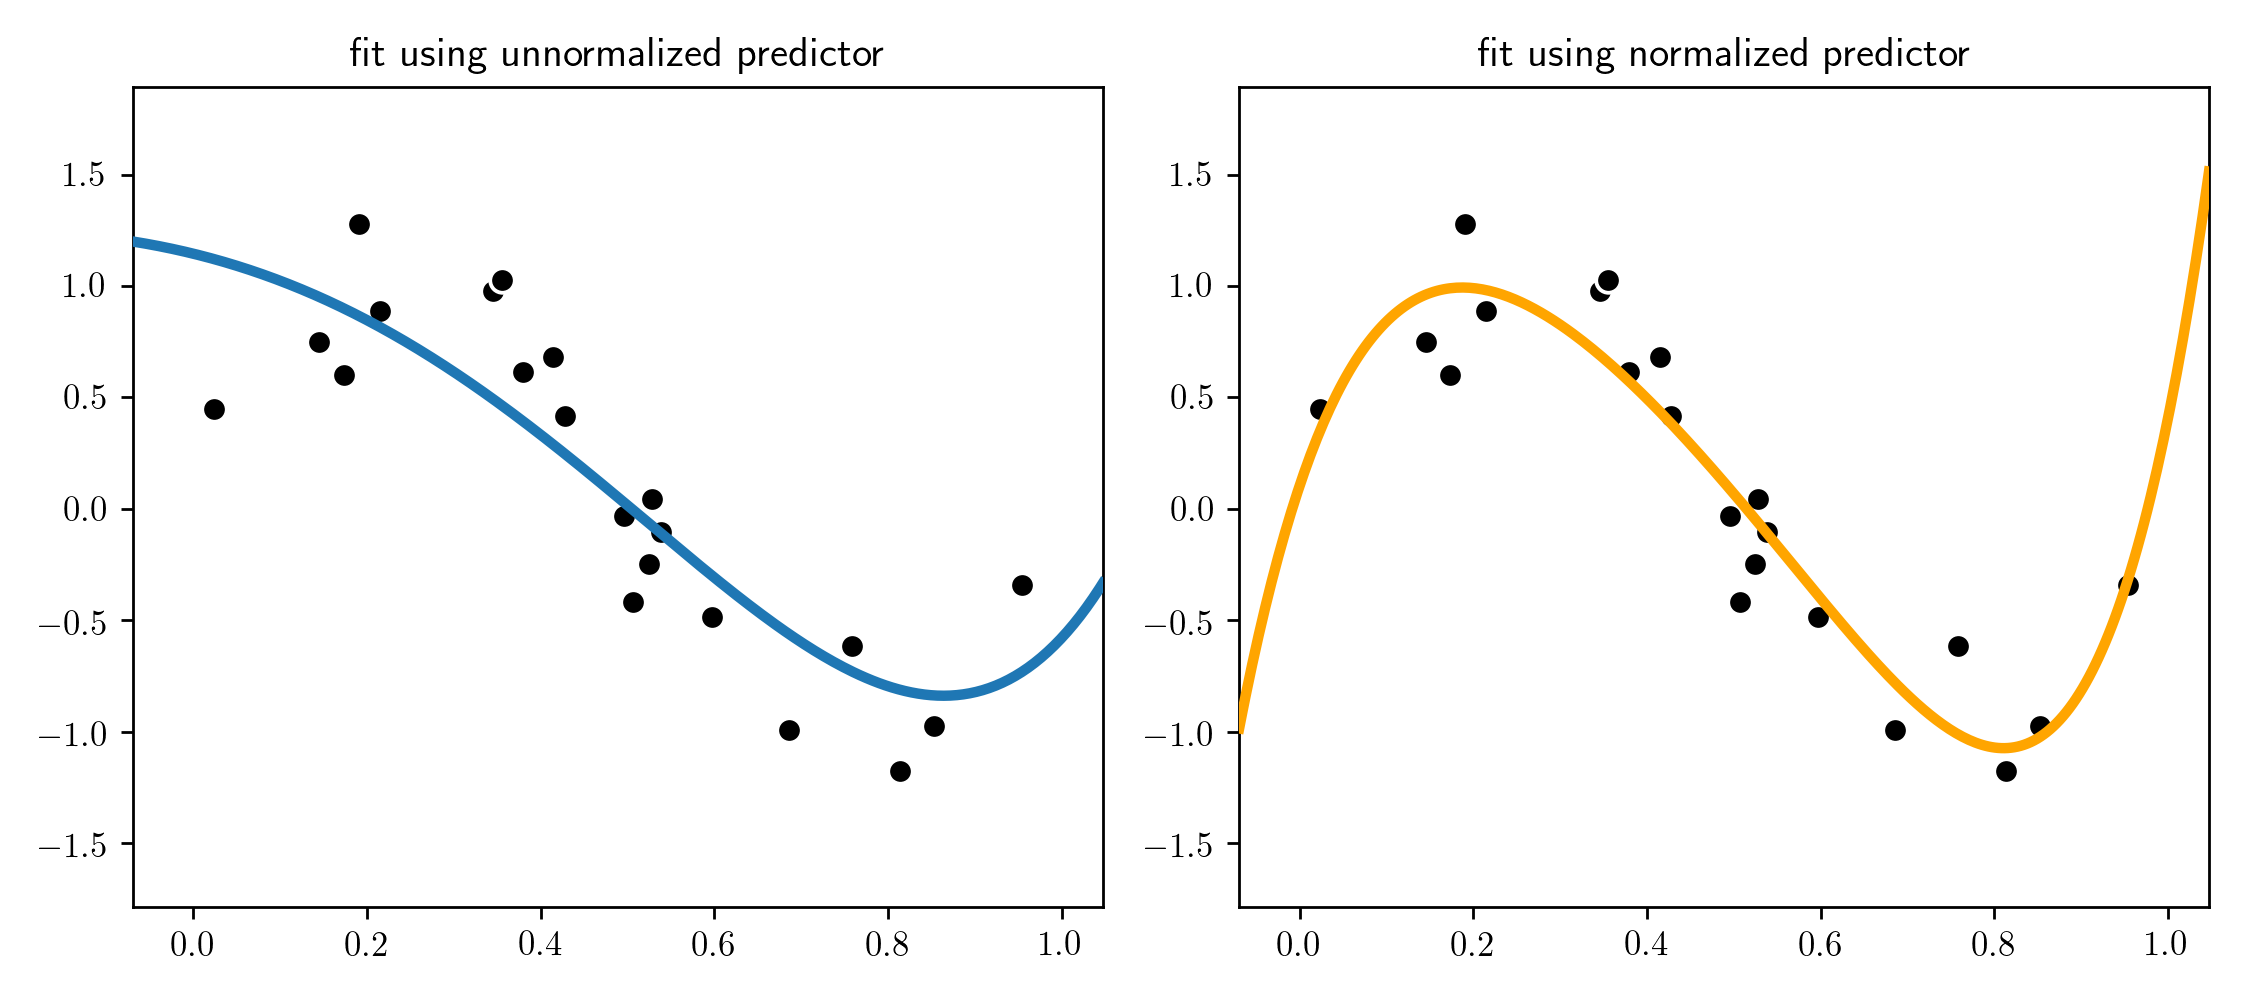

In [16]:
# compare final fits using unnormalized and normalized predictors
plotter_demo.compare_regression_fits(x,y,predict,predict_normalized,weight_history_1[-1],weight_history_2[-1],title1 = 'fit using unnormalized predictor',title2 = 'fit using normalized predictor')